In [1]:
# https://people.sc.fsu.edu/~jburkardt/data/ply/ply.html
# https://stackoverflow.com/questions/50965673/python-display-3d-point-cloud
%matplotlib inline
import numpy as np
import open3d as o3d
import numpy.matlib
import numpy
import matplotlib.pyplot as plt
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [2]:
pixelSize = 2e-03 # Approximation for a common pixel size of a camera in mm (2um -actually)

# Estimated Camera Parameters of a Huawei Y5-2017 Phone's Back Camera
alpha_x, alpha_y  = np.array([ 2700.1129,  2704.0118 ])*pixelSize # focal Length in pixels
beta_x , beta_y   = np.array([ 1179.3009,  1588.6612 ])*pixelSize # principal Pointin pixels
radialDistortion = [    0.0926,    -0.2114 ]

#Calculating Intrinsic Matrix K 3x3
IntrinsicMatrix = np.array([
    [alpha_x, 0      , beta_x],
    [0      , alpha_y, beta_y],
    [0      ,0       , 1     ]
]) 

In [3]:
# in rad
rotationVectors  = np.array([
 [    0.1588,   0.0631,  1.5096],
 [   -0.2234,   0.4752,  1.5148],
 [    0.2675,   0.7273,  1.5628],
 [   -0.5501,  -0.0713,  1.3859],
 [    0.5973,  -0.3509,  1.4462],
 [    0.7129,   0.5485,  1.4374],
 [   -0.3825,  -0.5195,  1.4603],
 [    0.5176,  -0.3308,  1.5007],
 [    0.0257,  -0.4419, -0.0002],
 [    0.0536,   0.7438, -0.0341],
 [   -0.1150,   0.4484,  1.5657],
 [   -0.4369,  -0.3818,  1.4392],
 [    0.7449,   0.5763,  1.4086],
 [    0.0326,  -0.6226,  1.5766],
 [    0.1588,  -0.0428,  1.5457],
 [   -0.2892,   0.4623,  1.5130],
 [    0.0113,   0.7785,  0.0270],
 [    0.3784,  -0.4751,  0.0885],
 [    0.3874,   0.7383, -0.1240],
 [   -0.8528,   0.1070, -0.0451]])

# in mm
translationVectors = np.array([
 [  155.9579, -149.0883,  504.5399 ],
 [  176.5537, -123.4080,  639.8593 ],
 [  180.8317, -134.0703,  507.8285 ],
 [   84.0470, -136.3349,  669.0573 ],
 [  119.6632,  -95.3260,  384.8297 ],
 [   82.4593, -132.8647,  290.4283 ],
 [  122.0913, -142.2950,  429.6691 ],
 [  122.5745, -161.9149,  367.3551 ],
 [ -103.7371, -130.3420,  402.5284 ],
 [  -66.6782,  -95.1525,  530.3091 ],
 [  152.3982, -125.6566,  615.8554 ],
 [  106.9474, -141.9626,  515.0723 ],
 [   76.2934, -131.5001,  327.6164 ],
 [  163.2290, -122.9659,  484.1596 ],
 [  123.0242, -136.7787,  453.6079 ],
 [  121.1290, -172.0656,  520.5429 ],
 [  -56.3611,  -82.7235,  537.3520 ],
 [  -51.0117,  -97.1251,  355.1822 ],
 [ -125.1265, -110.6333,  418.3420 ],
 [ -112.7127,  -53.8583,  577.6856 ]])

In [4]:
# Constructing the 
def getExtrinsicMatrix(rotationVector, translationVector):
    """
    Calculating Extrinsic Matrix [R|t] 3x4
    using 3D Rotation matrix and Translation Matrix
    """
    theta_1, theta_2, theta_3 = rotationVector   
    rotate_X = np.array([ # Rotation abot x axis
      [1,  0              ,  0               ,   0 ],
      [0,  np.cos(theta_1),  -np.sin(theta_1),   0 ],
      [0,  np.sin(theta_1),   np.cos(theta_1),   0 ],
      [0,  0              ,  0               ,   1 ]
    ])

    rotate_Y = np.array([ # Rotation abot y axis    
      [ np.cos(theta_2) , 0 , np.sin(theta_2)  , 0 ],
      [0                , 1 , 0                , 0 ],
      [-np.sin(theta_2) , 0 , np.cos(theta_2)  , 0 ],
      [0                , 0 , 0                , 1 ]
    ])


    rotate_Z = np.array([ # Rotation abot z axis
      [np.cos(theta_3) , -np.sin(theta_3), 0  ,  0 ],
      [np.sin(theta_3) ,  np.cos(theta_3), 0  ,  0 ],
      [0               ,  0              , 1  ,  0 ],
      [0               ,  0              , 0  ,  1 ]
    ])
    
    rotationMatrix   = rotate_X.dot(rotate_Y).dot(rotate_Z)
    
    translatioMatrix = np.eye(4) # last column can be replaced by the translation vector
    translatioMatrix[:-1,-1] = translationVector    
    ExtrinsicMatrix = rotationMatrix.dot(translatioMatrix)
    
    return np.array(ExtrinsicMatrix[:-1,:]) # First three rows only to make it 3x4

PointCloud with 2903 points.
[[ 6.92904522e-01 -5.20999678e+00  2.66481856e+00  2.22932079e+03]
 [ 5.82268171e+00  5.00950559e-01  2.27761347e+00  1.98255422e+03]
 [ 1.54029413e-01  7.18193135e-02  9.85452650e-01  5.10514866e+02]]


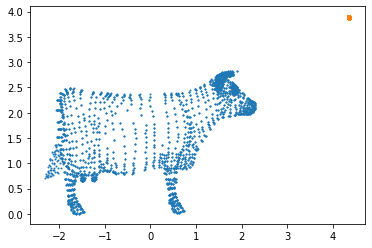

[[-3.11866364e-01 -3.77297243e+00  4.51584539e+00  3.30005949e+03]
 [ 4.45253109e+00  2.21838801e+00  3.82044741e+00  2.95689282e+03]
 [-2.46168694e-01  4.33048352e-01  8.67104434e-01  4.57921211e+02]]


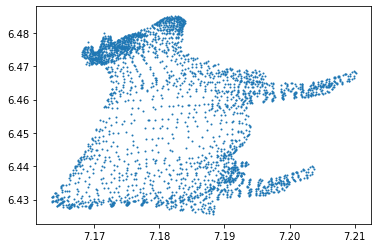

[[ 6.43570687e-01 -2.51639522e+00  5.28951917e+00  3.13992043e+03]
 [ 6.04663419e+00  1.13533510e+00  1.22119864e+00  1.56136790e+03]
 [ 2.59185462e-01  6.43302544e-01  7.20405950e-01  3.26463855e+02]]


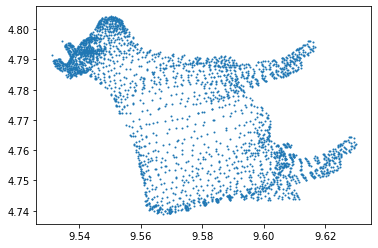

[[-1.95382360e-01 -5.66217240e+00  1.62082406e+00  1.83995457e+03]
 [ 2.97140736e+00  1.54547203e-01  5.52168003e+00  3.92298803e+03]
 [-5.02697142e-01 -1.55803578e-01  8.50306315e-01  5.47894925e+02]]


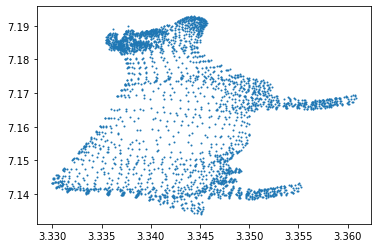

[[ 2.02974723e+00 -5.53217382e+00 -2.49031949e-02  7.60662561e+02]
 [ 6.19240961e+00  9.19110254e-01 -3.89097037e-01  5.03652349e+02]
 [ 5.93374159e-01 -2.12129789e-01  7.76471545e-01  3.90035847e+02]]


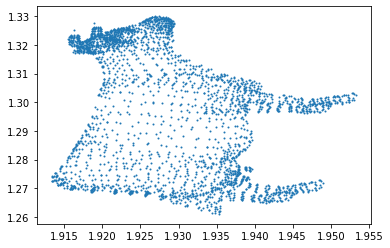

[[ 2.01803754e+00 -3.43991321e+00  4.33819810e+00  1.88338450e+03]
 [ 6.19286071e+00  2.34743770e-01 -9.67196226e-01  1.98568642e+02]
 [ 5.95760389e-01  4.77911124e-01  6.45500206e-01  1.73099994e+02]]


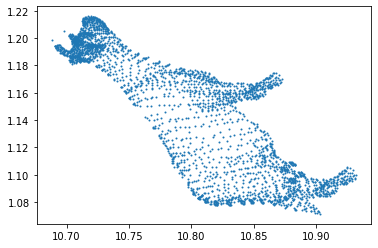

[[-2.38242971e-01 -5.83592416e+00 -7.81454171e-01  4.65568724e+02]
 [ 4.07980724e+00 -2.02793506e+00  4.31100327e+00  2.63897888e+03]
 [-3.20176936e-01 -4.98919295e-01  8.05336121e-01  3.77930949e+02]]


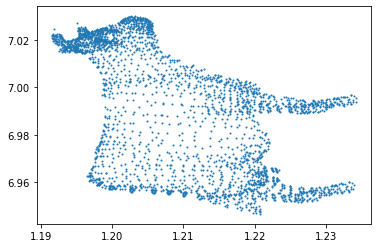

[[ 1.56850706e+00 -5.67725074e+00  1.84528519e-01  1.17927795e+03]
 [ 6.25828607e+00  4.11644046e-01  8.06319889e-02  7.30075554e+02]
 [ 5.13349620e-01 -2.46905850e-01  8.21893952e-01  4.04828244e+02]]


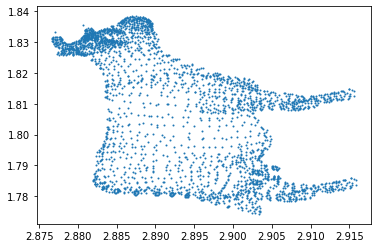

[[ 5.88981308e+00  6.17873576e-02 -1.78116057e-01 -6.90742388e+02]
 [ 1.29782816e+00  5.48814560e+00  2.74554127e+00  2.55189529e+02]
 [ 4.27511351e-01  2.57826738e-02  9.03642240e-01  3.16032312e+02]]


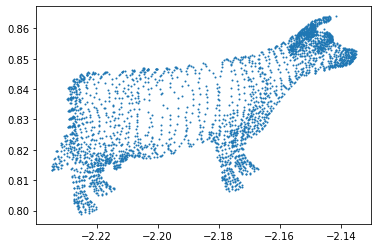

[[ 2.37364959e+00  2.07406873e-01  5.38963924e+00  2.68016877e+03]
 [-2.14084892e+00  5.50068891e+00  2.12162305e+00  7.44459660e+02]
 [-6.77550296e-01  3.04920774e-02  7.34844085e-01  4.31970942e+02]]


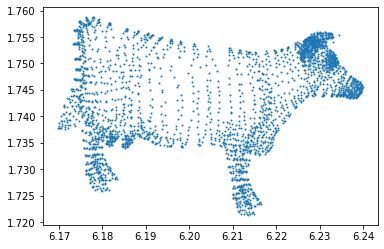

[[-2.51014336e-01 -3.85194178e+00  4.45252485e+00  3.18787924e+03]
 [ 4.99930563e+00  1.66287229e+00  3.40351228e+00  2.64900572e+03]
 [-1.16939977e-01  4.30070365e-01  8.95189658e-01  4.79444763e+02]]


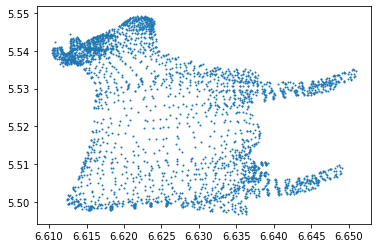

[[-2.27313316e-01 -5.88837282e+00 -2.89025515e-02  7.96731243e+02]
 [ 3.77748867e+00 -1.44204575e+00  4.79512046e+00  3.07854288e+03]
 [-3.75176259e-01 -3.90196299e-01  8.40826750e-01  4.48355723e+02]]


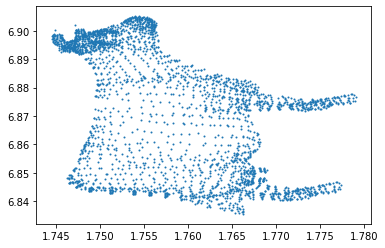

[[ 2.15653374e+00 -3.27791113e+00  4.39660118e+00  2.03597359e+03]
 [ 6.16624951e+00  2.74471875e-01 -1.11540533e+00  6.89259820e+01]
 [ 6.04308750e-01  5.04818128e-01  6.16416736e-01  1.81669367e+02]]


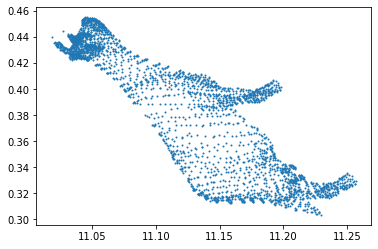

[[ 4.34370136e-02 -5.76198978e+00 -1.23411025e+00  1.18112116e+02]
 [ 5.49846872e+00 -1.78101799e+00  2.43657825e+00  2.29620678e+03]
 [ 2.92110864e-02 -5.83018781e-01  8.11933380e-01  4.69564866e+02]]


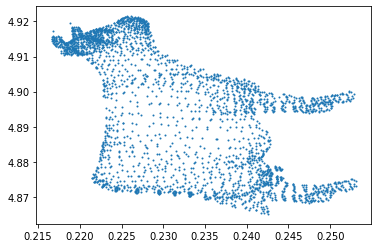

[[ 5.10744352e-01 -5.48383833e+00  2.09573340e+00  1.76354742e+03]
 [ 5.84302993e+00  4.89921960e-02  2.28006533e+00  1.74638864e+03]
 [ 1.59143797e-01 -3.82671230e-02  9.86513497e-01  4.72302981e+02]]


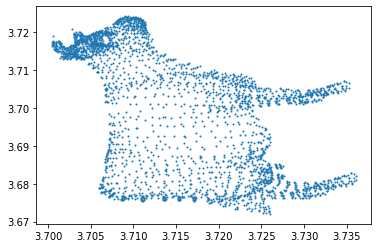

[[-4.50562941e-01 -3.85755678e+00  4.43189461e+00  2.91616786e+03]
 [ 4.15197931e+00  2.28979388e+00  4.10609409e+00  2.24632847e+03]
 [-3.09402730e-01  4.10298891e-01  8.57860577e-01  3.38477264e+02]]


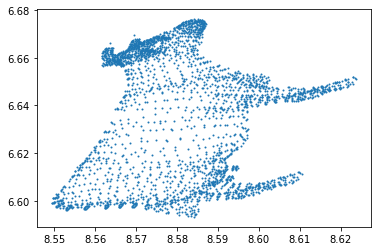

[[ 2.18857455e+00 -3.24445256e-02  5.47124574e+00  2.81931830e+03]
 [-2.04034419e+00  5.50066878e+00  2.21849847e+00  8.52076057e+02]
 [-7.01606445e-01  3.02518581e-02  7.11922202e-01  4.19593590e+02]]


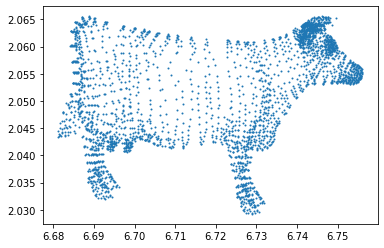

[[ 5.85899618e+00  3.54892342e-01 -5.21206662e-01 -5.18469638e+02]
 [ 9.82887791e-01  6.13639785e+00  8.48911026e-01 -3.44618946e+02]
 [ 4.56056279e-01  3.30418934e-01  8.26338912e-01  2.38144695e+02]]


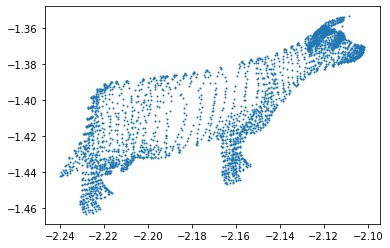

[[ 2.39471640e+00  1.19640884e+00  5.24970289e+00  1.76416607e+03]
 [-1.36805290e+00  6.08511354e+00  6.64771611e-01 -2.23934635e+02]
 [-6.65096519e-01  2.97808204e-01  6.84804274e-01  3.36756085e+02]]


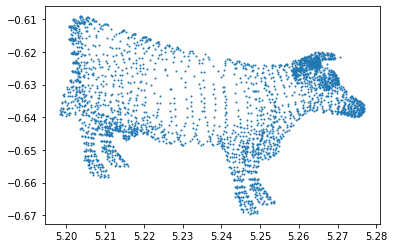

[[ 5.27842344e+00 -1.53991258e+00  2.11951796e+00  7.12406724e+02]
 [-7.10055065e-01  1.13403247e+00  6.12795962e+00  3.55898919e+03]
 [-3.62327082e-02 -7.55527196e-01  6.54114551e-01  4.22647854e+02]]


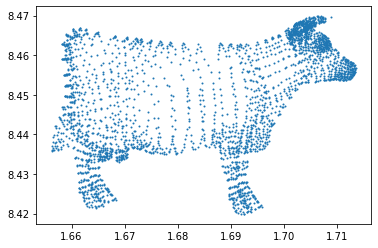

In [9]:
pcd = o3d.io.read_point_cloud("../Point cloud Related/pointClouds/"+"cow.ply") # Read the point cloud
print(pcd)
#o3d.visualization.draw_geometries([pcd])
points = np.asarray(pcd.points)
fig, ax = plt.subplots()
ax.scatter(points[:,0], points[:,1],s=1)
ones = np.ones((points.shape[0], 1))
points = np.concatenate((points, ones), axis=1) # Making the points homogeneous

# fig, ax = plt.subplots(4,5, figsize=(20,20))
location = 1
for i in range(20):   
    ExtrinsicMatrix = getExtrinsicMatrix(rotationVectors[i],translationVectors[i])
    CameraMatrix    =  IntrinsicMatrix.dot(ExtrinsicMatrix)
    print("="*80)
    print(CameraMatrix)
    
    P1 = CameraMatrix
    transfromed = np.matmul(P1, points.T).T
    transfromed = transfromed/np.matlib.repmat(transfromed[:,2], 3, 1).T # devide by the last coordinate
    
#     plt.subplot(4,5,location)
    plt.figure
    plt.scatter(transfromed[:,0], transfromed[:,1],s=1)
    plt.show()
#     location+=1